In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Data Ingestion

Let's see how we can get the images from the data directory.

In [2]:
!tree -d /kaggle/input

/kaggle/input
└── tire-texture-image-recognition
    └── Tire Textures
        ├── testing_data
        │   ├── cracked
        │   └── normal
        └── training_data
            ├── cracked
            └── normal

8 directories


In [3]:
import os
TRAIN_DIR_LOCATION = '/kaggle/input/tire-texture-image-recognition/Tire Textures/training_data'
TEST_DIR_LOCATION = '/kaggle/input/tire-texture-image-recognition/Tire Textures/testing_data'

for dirname, directories, filenames in os.walk(TRAIN_DIR_LOCATION):
    print(f"There are {len(directories)} directories and {len(filenames)} files in '{dirname}'.")
    
print("============================================================================================================================")
for dirname, directories, filenames in os.walk(TEST_DIR_LOCATION):
    print(f"There are {len(directories)} directories and {len(filenames)} files in '{dirname}'.")

There are 2 directories and 0 files in '/kaggle/input/tire-texture-image-recognition/Tire Textures/training_data'.
There are 0 directories and 327 files in '/kaggle/input/tire-texture-image-recognition/Tire Textures/training_data/cracked'.
There are 0 directories and 376 files in '/kaggle/input/tire-texture-image-recognition/Tire Textures/training_data/normal'.
There are 2 directories and 0 files in '/kaggle/input/tire-texture-image-recognition/Tire Textures/testing_data'.
There are 0 directories and 210 files in '/kaggle/input/tire-texture-image-recognition/Tire Textures/testing_data/cracked'.
There are 0 directories and 115 files in '/kaggle/input/tire-texture-image-recognition/Tire Textures/testing_data/normal'.


# Expoloratory Data Analysis

In [4]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_random_image(target_set, target_class):
    folder = os.path.join(target_set, target_class)
    image_path = random.sample(os.listdir(folder), 1)
    print(folder)
    print(image_path)
    
    img = mpimg.imread(os.path.join(folder, image_path[0]))
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    print(img.shape)

/kaggle/input/tire-texture-image-recognition/Tire Textures/training_data/cracked
['Cracked-246.jpg']
(258, 258, 3)


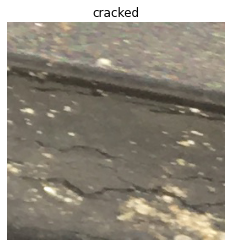

In [5]:
show_random_image(TRAIN_DIR_LOCATION, 'cracked')

# Data Pre-processing

We use the Tensorflow's ImageDataGenerator to retrieve the train and validation data from the directory.

In [6]:
import tensorflow as tf

tf.random.set_seed(42)
PIXEL_SIZE = (224, 224)

# normalize the pixel values
train_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_data = train_img_gen.flow_from_directory(TRAIN_DIR_LOCATION,
                                  #resize the images for uniformity and less data
                                  target_size=PIXEL_SIZE,
                                  batch_size=32,
                                  class_mode='binary')



# do the same for validation data
valid_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_data = train_img_gen.flow_from_directory(TEST_DIR_LOCATION,
                                  #resize the images for uniformity and less data
                                  target_size=PIXEL_SIZE,
                                  batch_size=32,
                                  class_mode='binary')

Found 703 images belonging to 2 classes.
Found 325 images belonging to 2 classes.


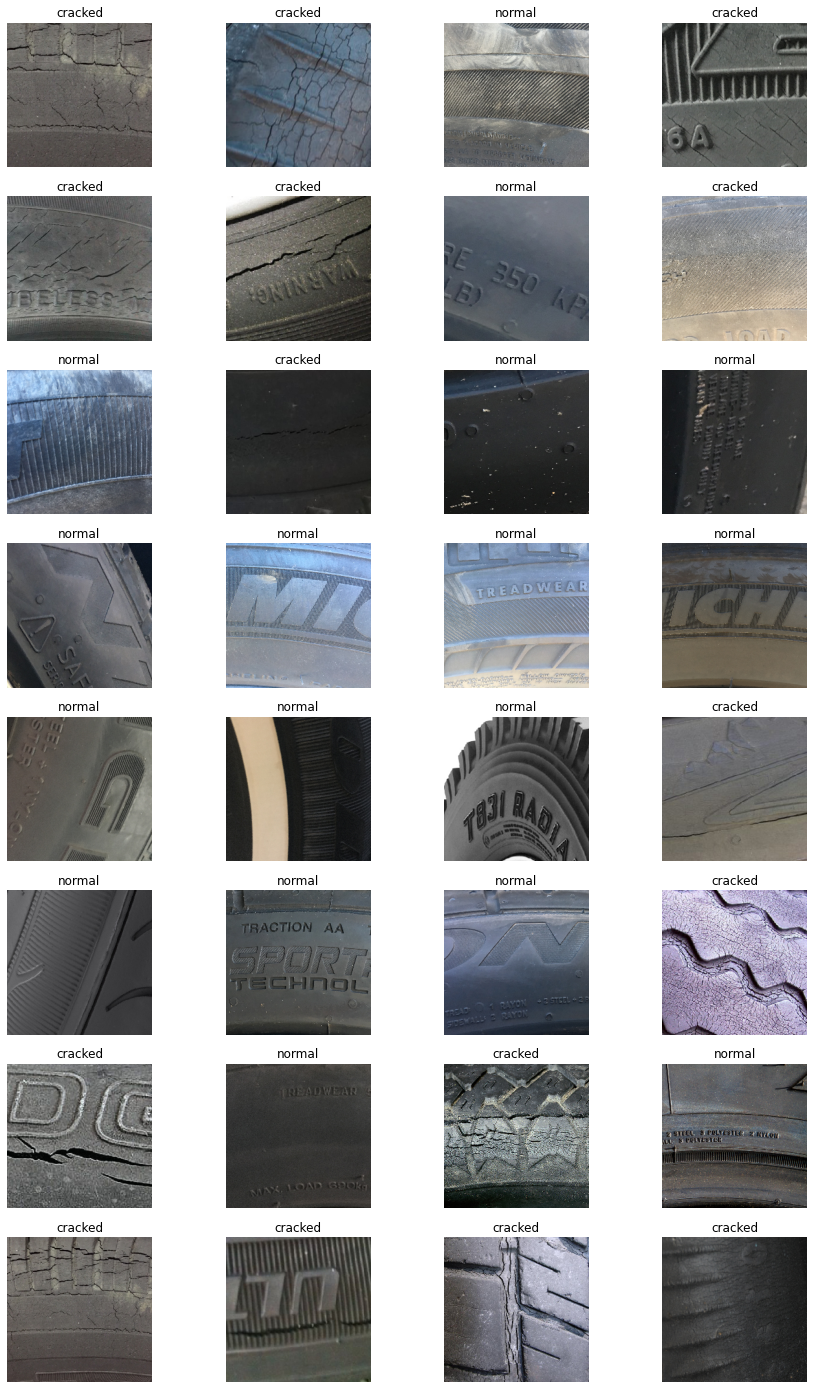

In [7]:
def show_images(images, labels):
    fig, axs = plt.subplots(8, 4, figsize=(15, 25))
    for index, image in enumerate(images):
        row = index // 4
        col = index % 4
        
        axs[row, col].imshow(image)
        axs[row, col].set_title(f"{labels[index]}")
        axs[row, col].axis('off')
    plt.show()
    
class_lookup = {v:k for k,v in train_data.class_indices.items()}
labels = [class_lookup[int(x)] for x in train_data[0][1]]
show_images(train_data[0][0],labels)